## Importowanie bibliotek oraz danych

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
NUM_CLASSES = 10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

W moim ćwiczeniu potrzebuję na wejściu stworzyć 7 wejść, możliwe nachodzących na siebie. Dlatego muszę zrezygnować z warstwy Flatten i wykonać spłaszczenie wymiaru obrazu jeszcze przed etapem 

In [5]:
flat = np.prod(x_train.shape[1:])

In [6]:
x_train_bis = x_train.reshape(len(x_train), flat)   # (liczba wierszy, flatten)
x_test_bis = x_test.reshape(len(x_test), flat)   # (liczba wierszy, flatten)


In [7]:
print(x_train_bis.shape)
print(x_test_bis.shape)


(50000, 3072)
(10000, 3072)


W następnym kroku tworzę po 7 podzbiorów treningu oraz testu w rozumieniu "cech" ze zbioru treningowego. Podzbiory mogą na siebie nachodzić analogicznie jak nachodza na siebie cechy w sieci splotowej przy wyborze kilku kanałów. Chciałbym aby zbiory nachodziły na siebie w 33%% z sąsiednimi podzbiorami. Mamy 3072 elementów więc 3072/7*1.66=729 elementów. Zbiory więc nachodzą  w 243 elementach na lewo i prawo

In [8]:
X_train_pik = x_train_bis[:, list(np.arange(0,2*243))+list(np.arange(3072-243,3072))]
X_train_kier = x_train_bis[:, list(np.arange(0,3*243))]
X_train_trefl = x_train_bis[:, list(np.arange(243,4*243))]
X_train_drop  = x_train_bis[:, list(np.arange(2*243,5*243))]
X_train_sun  = x_train_bis[:, list(np.arange(3*243,6*243))]
x_train_flow = x_train_bis[:, list(np.arange(4*243,7*243))]
X_train_inf = x_train_bis[:, list(np.arange(5*243,7*243))+list(np.arange(0,243))]


X_test_pik = x_test_bis[:, list(np.arange(0,2*243))+list(np.arange(3072-243,3072))]
X_test_kier = x_test_bis[:, list(np.arange(0,3*243))]
X_test_trefl = x_test_bis[:, list(np.arange(243,4*243))]
X_test_drop  = x_test_bis[:, list(np.arange(2*243,5*243))]
X_test_sun  = x_test_bis[:, list(np.arange(3*243,6*243))]
x_test_flow = x_test_bis[:, list(np.arange(4*243,7*243))]
X_test_inf = x_test_bis[:, list(np.arange(5*243,7*243))+list(np.arange(0,243))]


In [9]:
#sprawdzam czy liczności się w miarę spinają
print(X_train_pik.shape)
print(X_train_kier.shape)
print(X_train_trefl.shape)
print(X_train_drop.shape)
print(X_train_sun.shape)
print(x_train_flow.shape)
print(X_train_inf.shape)


(50000, 729)
(50000, 729)
(50000, 729)
(50000, 729)
(50000, 729)
(50000, 729)
(50000, 729)


Teraz przygotowuję topologię mojej sieci. Węzeł Dense wymaga płaskiego wejścia i takie dostanie

In [10]:
#warstwa wejść. Swiadomie nie korzystam z interfejsu podklasowego w którym nie mógłbym wyświelić struktury modelu
input_pik = Input(shape=[729], name ='pik')
input_kier = Input(shape=[729], name ='kier')
input_trefl = Input(shape=[729], name ='trefl')
input_drop  = Input(shape=[729], name ='drop')
input_sun  = Input(shape=[729], name ='sun')
input_flow = Input(shape=[729], name ='flow')
input_inf = Input(shape=[729], name ='inf')

#teraz dla każdego wejścia trenuję po jednym Dense w warstwie ukrytej
hi_pik = Dense(150, activation = 'relu')(input_pik)
hi_kier = Dense(150, activation = 'relu')(input_kier)
hi_trefl = Dense(150, activation = 'relu')(input_trefl)
hi_drop  = Dense(150, activation = 'relu')(input_drop)
hi_sun  = Dense(150, activation = 'relu')(input_sun)
hi_flow = Dense(150, activation = 'relu')(input_flow)
hi_inf = Dense(150, activation = 'relu')(input_inf)

#teraz warstwy konkatenacji po 3 elementy Dense

concat1 = concatenate([hi_pik, hi_sun, hi_inf])
concat2 = concatenate([hi_inf,hi_kier,hi_flow])
concat3 = concatenate([hi_inf,hi_trefl, hi_drop])
concat4 = concatenate([hi_drop,hi_pik,hi_flow])
concat5 = concatenate([hi_drop,hi_kier,hi_sun])
concat6 = concatenate([hi_sun,hi_trefl,hi_flow])
concat7 = concatenate([hi_pik,hi_trefl, hi_kier])

#konkatenacja master: do zastanowienia czy same warstwy concat_ czy również dane wejściowe albo nawet warstwy ukryte
concat_master = concatenate([concat1,concat2,concat3,concat4,concat5,concat6,concat7])
output = Dense(NUM_CLASSES, activation = 'softmax')(concat_master)

model = Model(inputs = [input_pik, input_kier, input_trefl, input_drop, input_sun, input_flow, input_inf] , outputs =  [output])



W0112 22:28:31.867794 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0112 22:28:31.873782 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pik (InputLayer)                (None, 729)          0                                            
__________________________________________________________________________________________________
sun (InputLayer)                (None, 729)          0                                            
__________________________________________________________________________________________________
inf (InputLayer)                (None, 729)          0                                            
__________________________________________________________________________________________________
kier (InputLayer)               (None, 729)          0                                            
__________________________________________________________________________________________________
flow (Inpu

In [12]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

W0112 22:28:44.264054 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0112 22:28:44.271362 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Dorzucam jeszcze funkcję do zapisywania historii procesu szkolenia modelu aby móc go porównać z prostym modelem sekwencyjnym

In [13]:
import os
import datetime
#print(os.curdir)
root_logdir = os.path.join(os.curdir,'historia')

def get_run_logdir():
    import time
    run_id = time.strftime("przebieg_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

In [14]:
from tensorflow import keras
# inicjuję katalog do zapisania historii przebiegu
run_logdir = get_run_logdir()
# inicjuję odwołanie zwrotne
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

historia = model.fit([X_train_pik, X_train_kier, X_train_trefl, X_train_drop, X_train_sun, x_train_flow, X_train_inf]
                   , y_train
                   , batch_size=32
                   , epochs=40
                   , shuffle=True
                   , callbacks=[tensorboard_cb])

W0112 22:28:57.418919 19704 deprecation.py:323] From E:\Python\Anaconda\envs\generative\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0112 22:28:57.489730 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0112 22:28:57.582180 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0112 22:28:57.682291 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use

Epoch 1/40


W0112 22:28:58.013330 19704 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



50000/50000 [==============================] - 16s 326us/step - loss: 1.8345 - acc: 0.3480
Epoch 2/40
50000/50000 [==============================] - 16s 314us/step - loss: 1.6538 - acc: 0.4153
Epoch 3/40
50000/50000 [==============================] - 16s 315us/step - loss: 1.5899 - acc: 0.4405
Epoch 4/40
50000/50000 [==============================] - 16s 313us/step - loss: 1.5447 - acc: 0.4566
Epoch 5/40
50000/50000 [==============================] - 16s 316us/step - loss: 1.5124 - acc: 0.4652
Epoch 6/40
50000/50000 [==============================] - 16s 314us/step - loss: 1.4801 - acc: 0.4780
Epoch 7/40
50000/50000 [==============================] - 16s 314us/step - loss: 1.4566 - acc: 0.4881
Epoch 8/40
50000/50000 [==============================] - 16s 316us/step - loss: 1.4280 - acc: 0.4996
Epoch 9/40
50000/50000 [==============================] - 16s 315us/step - loss: 1.4052 - acc: 0.5043
Epoch 10/40
50000/50000 [==============================] - 16s 316us/step - loss: 1.3857 - ac

In [15]:
model.evaluate([X_test_pik, X_test_kier, X_test_trefl, X_test_drop, X_test_sun, x_test_flow, X_test_inf], y_test)

10000/10000 [==============================] - 1s 60us/step


[1.6803671974182128, 0.4957]

In [16]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict([X_test_pik, X_test_kier, X_test_trefl, X_test_drop, X_test_sun, x_test_flow, X_test_inf])
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

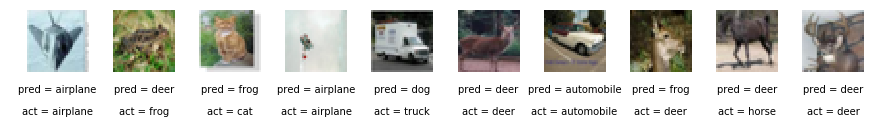

In [17]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)